In [2]:
%pip install ipympl
%pip install matplotlib numpy sympy scipy h5py
%matplotlib widget
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In this script we will showcase the steps taken in order to extract and listen to the signal produced by the collision of two black holes.
The steps performed are the following:
- Load the dataset and plot the values as a sanity check
- Use a subset of the dataset that doesn't contain the anomaly to estimate the _Power Density Spectrum_ of the noise present
- Window the subdataset to reduce the errors caused by the edge discontinuities
- Apply techniques to denoise the estimated _PDS_
- Construct a Whitening Filter from the denoised _PDS_
- Apply the Whitening Filter to the sample with the anomaly present and extract the desired uncorrelated signal
- Save the signal to a .wav file


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import h5py as hdf
import main
import importlib

# H1
h1 = main.SignalProcessor(name="H1-4096-4K")

1a) Periodogram

The anomaly starts at GPS Time 1126259462s, so we calculate the number of samples so that the resulting subdataset does not contain it. We make sure the number is even so that the FIR filter design later results in a type I with no restrictions.

The subdataset containing the N datapoints should be as big as possible to improve the frequency resolution of the periodogram and reduce the variance in the power spectral density (PSD) estimate. 
We choose the data prior to the anomaly because there might be a slow system recovery or instrument artifacts, which can affect the noise characteristics.

According to the paper https://arxiv.org/pdf/1908.11170, a 1024s second sample is a good amount of data for a noise estimation.

Maximum n value:  4194303  out of  16777216


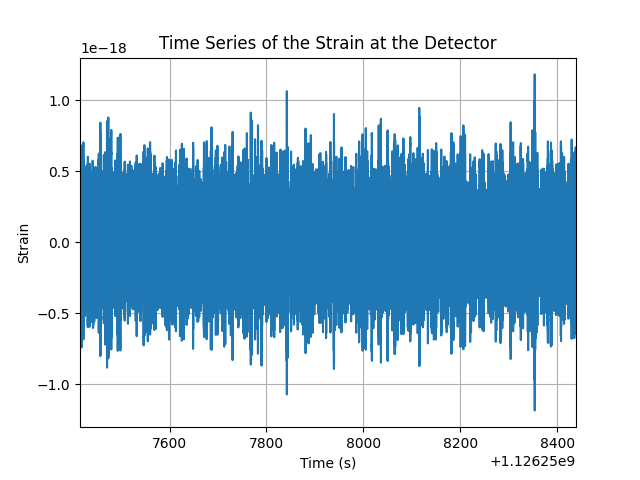

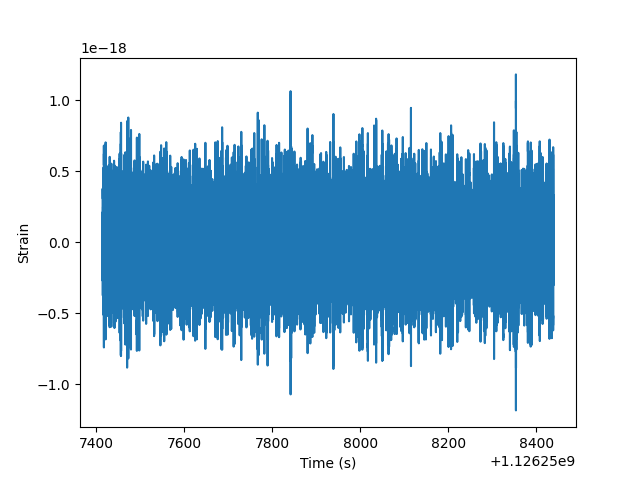

In [4]:
anomaly_time = 1126259462
start_time = anomaly_time - 1024
xValues_h1, yValues_h1, N = h1.Subdataset(startTime=start_time, endTime=anomaly_time)
main.plotSubdataset(xValues_h1, yValues_h1)

In this stage we multiply the dataset by a window to reduce the spectral leakage. The chosen window was a Dolph Chebyshev window with 100 dB of equiripple attenuation. 

In [5]:
importlib.reload(main)
h1.WindowSubdataset()

In this stage we first estimate the _PDS_ using a periodogram. This is calculated by taking the modulus squared of the FFT of the signal.

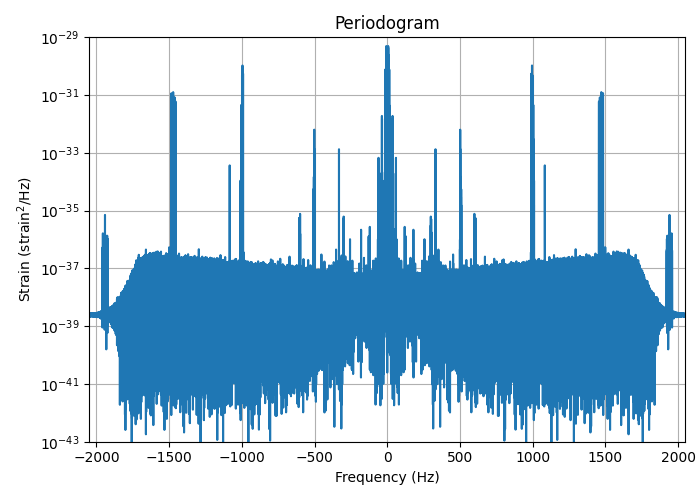

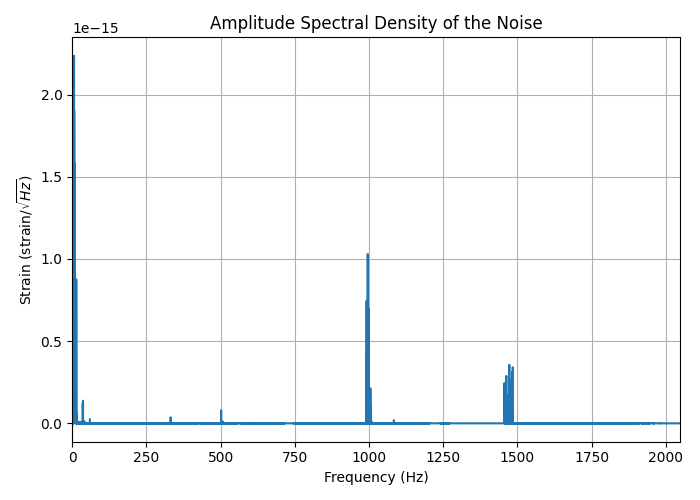

In [6]:
f_h1, R_y_h1 = h1.Periodogram()
main.periodogram_plotting(f_h1, R_y_h1, title="Periodogram")
main.ASD(f_h1, R_y_h1)


In the ASD you can see the distrubances in LIGO Detection Zone. These can be caused by vibtations at Suspensions of the Mirrors or by noise in the Laser. I need a source. There is only the part greater than zero at display for showcasing reasons.

1b) Periodogram smoothing

In this stage we apply a Periodogram Smoothing technique to reduce the variance of the Periodogram. 

The L-factor represents the ratio of zero and nonzero samples in the rectangular Low Pass filter.

The factor $N$ was already discussed in the part 1a) and it`ll stay the same. 

The quantity $\Delta f \approx \left(\frac{1}{N} \right)(2M + 1)$ determines the frequency resolution (see Manolakis et all).

The human ear has a frequency resolution of approximately 3.6Hz.

If we aim for a deltaF of 3Hz with Fs of 4KHz, then that is a normalized frequency of 0.00075 and therefore M can be calculated from the previous expression:

(0.00075 * N - 1) / 2 = M = 1535 ~= 1500

C:\Users\jtori\PycharmProjects\PASA-P1-Marco\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jtori\PycharmProjects\PASA-P1-Marco\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


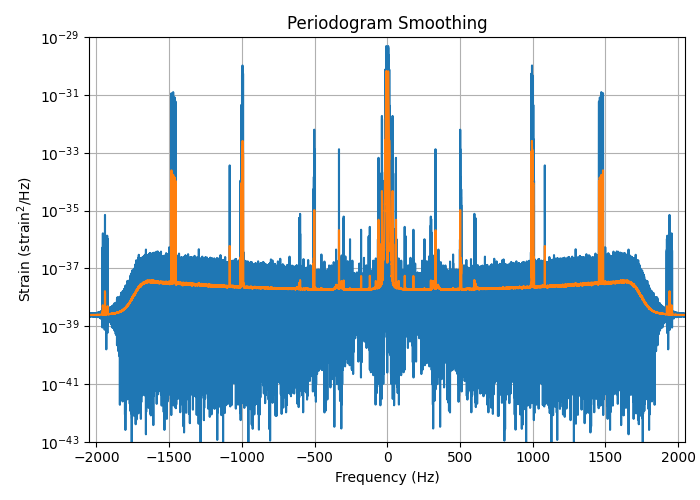

In [7]:
# The recommended L range goes from 0.1N to 0.2N
m = 1500
f_PS_h1, R_y_PS_h1 = h1.PeriodogramSmoothing(m=1500)
main.periodogram_plotting([f_h1, f_PS_h1], [R_y_h1, R_y_PS_h1], title="Periodogram Smoothing")

1c) Periodogram Averaging

The aim is to optimize periodogram averaging by adjusting the following parameters:

1. Segment Length (L):
This is the length of each data segment used for averaging.
Frequency resolution is inversely proportional to L.
A larger L gives better frequency resolution but fewer segments. In our case, we chose $L=750$ empirically after testing different values. It offered a reasonable balance between resolution and smoothness of the spectrum, while maintaining sufficient segment count.

2. Overlap Factor (D):
This controls how much the segments overlap.
Increasing overlap increases the number of segments (K).
A larger K reduces the variance of the power spectral density (PSD) estimate.
In Manolakis et all. there is the recommandation to use $D = 0.5$

3. Window: We choose Hanning. The window does not affect the variance. But it helps to suppres the side lobes

TODO error skaling factor to take in account. FFT introduces some kind of gain or the window. 

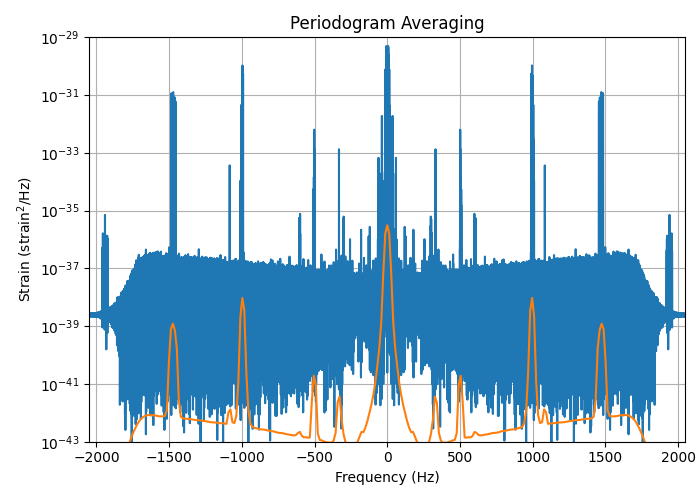

Number of segments K: 27961


In [8]:
f_PA_h1, R_y_PA_h1, K_h1 = h1.PeriodogramAveraging(L=300, D=0.5, window='Hanning')
main.periodogram_plotting([f_h1, f_PA_h1], [R_y_h1, R_y_PA_h1], title="Periodogram Averaging")    
print(f"Number of segments K: {K_h1}")

1d) The best method

The Literature recommends the averaged periodogram. Because it has in general lower variance and the spectral estimate is statistically more stable.

Periodogram averaging reduces the variance of the Periodogram better than the smoothing, because the each segment provides an independent estimate. The averaging over many segments leads to more stable and less noisy result. You can see this in the following plot. The periodogram averaging is more smooth than the periodogram smoothing. 

Furthermore averaging periodogram doesnt have the Bias-Variance Trade as smoothing. Smoothing trades frequency resolution for lower variance, but it can introduce bias near peaks. You can notice this in the following plot at the peak at the $f=1000 Hz$.  

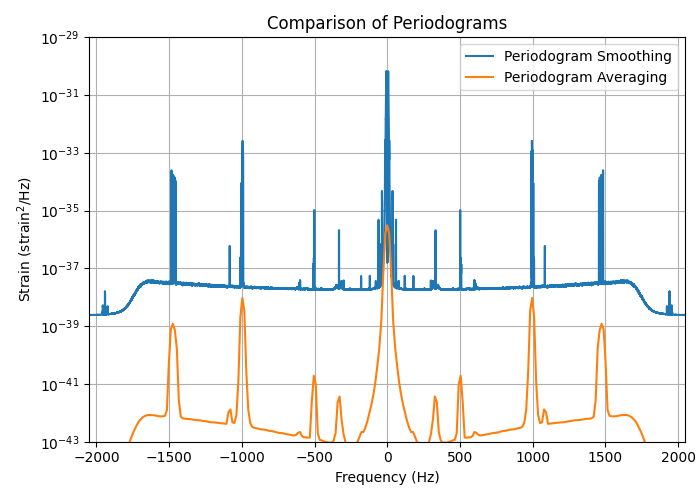

In [9]:
# main.periodogram_plotting([f_h1, f_PS_h1, f_PA_h1], [R_y_h1, R_y_PS_h1, R_y_PA_h1], title="Comparison of Periodograms", ylim=(1e-43, 1e-29), labels=["Periodogram", "Periodogram Smoothing", "Periodogram Averaging"])
main.periodogram_plotting([f_PS_h1, f_PA_h1], [R_y_PS_h1, R_y_PA_h1], title="Comparison of Periodograms", ylim=(1e-43, 1e-29), labels=["Periodogram Smoothing", "Periodogram Averaging"])

1e) Comparison of H1 and L1

Maximum n value:  61439  out of  131072


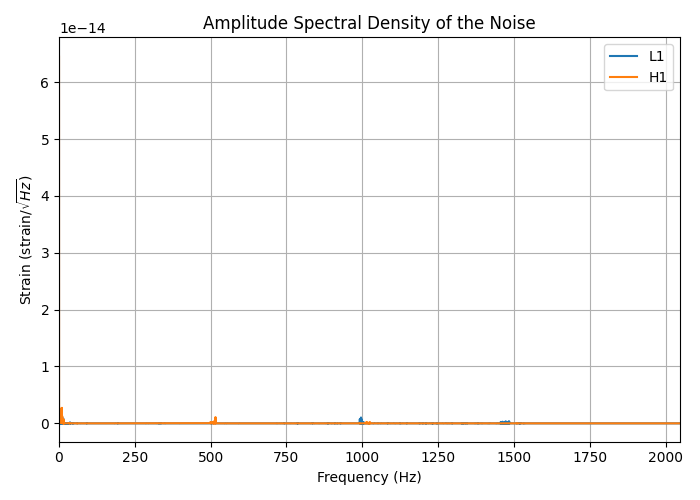

C:\Users\jtori\PycharmProjects\PASA-P1-Marco\.venv\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


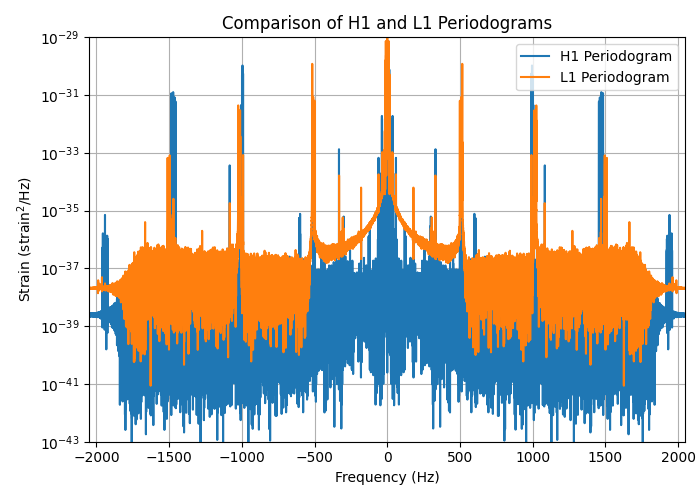

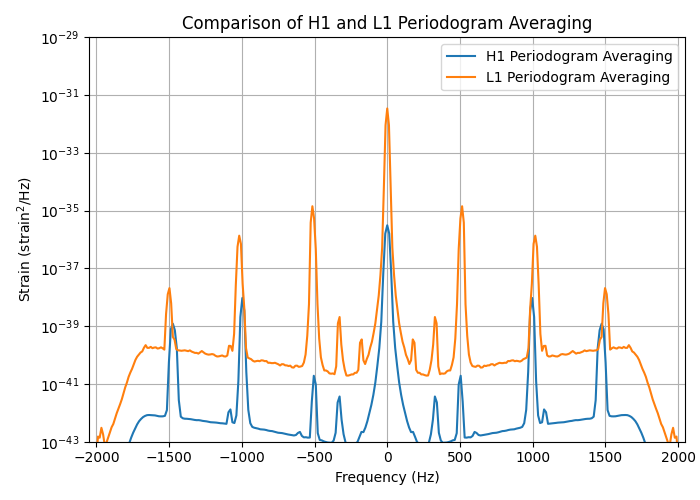

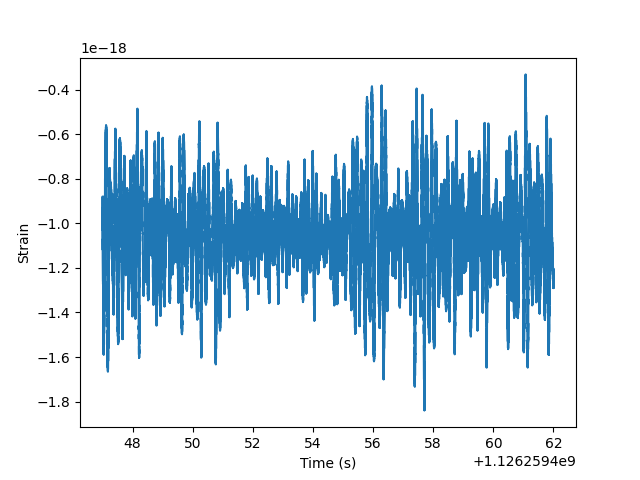

In [10]:
L1 = main.SignalProcessor(name="L1-32-4K")
L1.Subdataset(endTime=anomaly_time)
# L1.WindowSubdataset()
f_L1, R_y_L1 = L1.Periodogram()
# main.periodogram_plotting(f_L1, R_y_L1, title="Periodogram L1")
main.ASD([f_h1, f_L1], [R_y_h1, R_y_L1], labels=["L1", "H1"])
main.periodogram_plotting([f_h1, f_L1], [R_y_h1, R_y_L1], title="Comparison of H1 and L1 Periodograms", ylim=(1e-43, 1e-29), labels=["H1 Periodogram", "L1 Periodogram"])    
f_PA_L1, R_y_PA_L1, K_L1 = L1.PeriodogramAveraging(L=350, D=0.5, window = 'Hanning')
main.periodogram_plotting([f_PA_h1, f_PA_L1], [R_y_PA_h1, R_y_PA_L1], title="Comparison of H1 and L1 Periodogram Averaging", ylim=(1e-43, 1e-29), labels=["H1 Periodogram Averaging", "L1 Periodogram Averaging"])


Amplitude spectral density analysis:
When comparing our results to the LIGO noise and sensitivity plot provided in the task sheet, we can attribute the low-frequency disturbances to suspension thermal noise, as expected. Additionally, the spectral peaks observed around 1000 Hz and 1400 Hz correspond to noise sources that can affect LIGO's sensitivity. We can also see that the noise in L1 has more energy because it has a higher amplitude than the noise in H1. Furthermore the amplitude peaks between L1 and H1 are also shifted (f.e. at $f=1000Hz$). 

Power spectal density analysis:
The nose of H1 has in general a lower noise level. That fits to our observation in the ASD. 
Peak comparison: Furthermore for low frequencys are the peaks in L1 higher than in H1. It goes even so far, that L1 has a peak at 175 Hz and H1 not.On the other side the peaks for frequencys above ca. $f=1250Hz$ are higher in H1.
Bias: If we compare the averaged periodograms to the original periodograms. Lets say at the peak at the frequency ca. $500Hz$.
(H1: originally 501.8; averaged 505.125 -
L1: originally 515.9; averaged 514.925) 
These are all values estimated by eye, but we think it is clear that L1 leads to less bais.
Variance: After ajusting the parameters of the averaging, the variance is almost equal.


1f) Validation of the stationarity

A signal is stationary if its statistical properties (mean, variance, autocorrelation, ...) stay the same over time. That means the stationary signal is in the frequency domain always the same, it doesnt matter at which timewindow we look at it. So these are the two closest options to validate the stationary on the hand.

But after some research we found different methods to test for stationarity. For example the augmented Dickey-Fuller or Kwiatkowski-Phillips-Schmidt-Shin test. 

As you can see in the plots of periodograms and in the statistical properties the signals are non stationary and the Augmented Dickey-Fuller Test support this result also.

Signal: H1-4096-4K


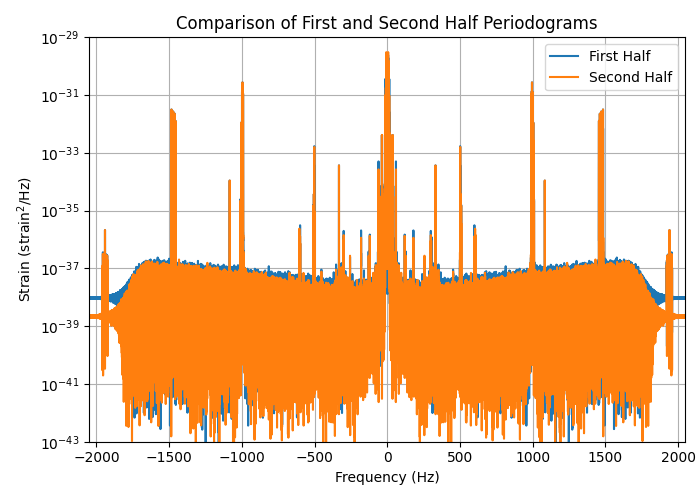

Signal: L1-32-4K


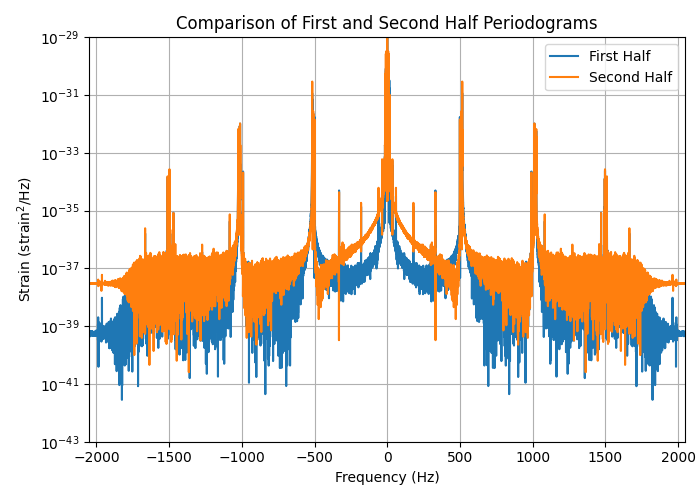

In [11]:
# split the data in two parts and compare the periodograms to check if the signal is stationary
signals = [h1, L1]
for signal in signals:
    print(f"Signal: {signal.name}")
    N_half = int(signal.max_n/2)
    f_signal_first, R_y_signal_first = signal.Periodogram(signal.xValues[:N_half], signal.yValues[:N_half], max_n = N_half)
    f_signal_second, R_y_signal_second = signal.Periodogram(signal.xValues[N_half+1:], signal.yValues[N_half+1:], max_n = N_half)
    main.periodogram_plotting([f_signal_first, f_signal_second], [R_y_signal_first, R_y_signal_second], title="Comparison of First and Second Half Periodograms", ylim=(1e-43, 1e-29), labels=["First Half", "Second Half"])

Signal: H1-4096-4K
First Half: Mean = -3.438236011418059e-24, Variance = 1.952371405586948e-40
Second Half: Mean = 3.4406074573135124e-24, Variance = 1.9031156157800268e-40
Signal: L1-32-4K
First Half: Mean = -1.0528263520053925e-18, Variance = 3.7104555819694683e-38
Second Half: Mean = -1.0520854265733727e-18, Variance = 5.937318329254746e-38


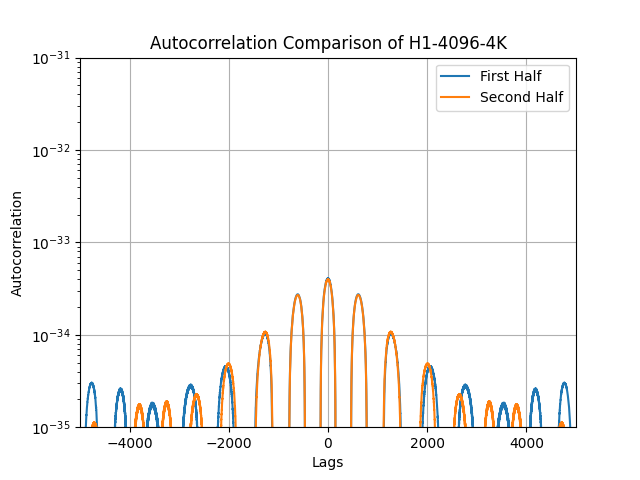

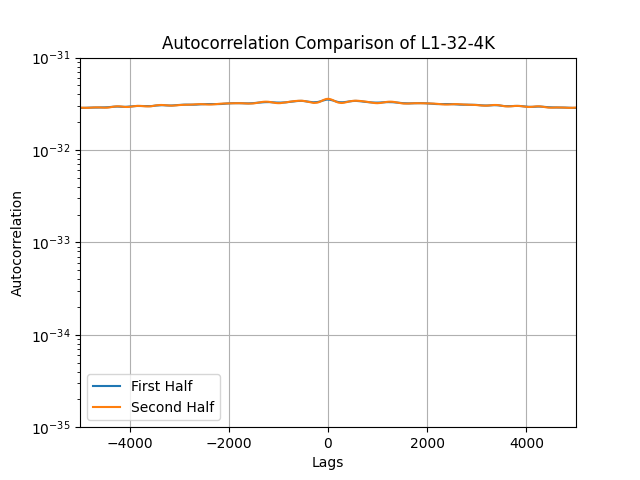

In [12]:
# Calculation of the variance, mean and autocorrelation of the two halves of the signal to compare them and check if they are stationary
for signal in signals:
    print(f"Signal: {signal.name}")
    N_half = int(signal.max_n/2)
    mean_first = np.mean(signal.yValues[:N_half])
    mean_second = np.mean(signal.yValues[N_half:])
    var_first = np.var(signal.yValues[:N_half])
    var_second = np.var(signal.yValues[N_half:])
    auto_corr_first = sp.correlate(signal.yValues[:N_half], signal.yValues[:N_half], mode='full')
    auto_corr_second = sp.correlate(signal.yValues[N_half+1:], signal.yValues[N_half+1:], mode='full')
    # print the results
    print(f"First Half: Mean = {mean_first}, Variance = {var_first}")
    print(f"Second Half: Mean = {mean_second}, Variance = {var_second}")   
    # plot the autocorrelations
    lags = np.arange(-N_half + 1, N_half) 
    plt.figure()
    plt.plot(lags, auto_corr_first, label='First Half')
    plt.plot(lags, auto_corr_second, label='Second Half')
    plt.title(f'Autocorrelation Comparison of {signal.name}')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-35, 1e-31)
    plt.xlim(-5000, 5000)
    plt.grid(True)

In [13]:
# Implementation of augmented Dickey-Fuller test
# TODO: Remember to uncomment this for the final revision
# from statsmodels.tsa.stattools import adfuller
# for signal in signals:
#     print(f"Signal: {signal.name}")
#     result = adfuller(signal.yValues)
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     for key, value in result[4].items():
#         print('Critial Values:')
#         print(f'   {key}, {value}')
#     if result[1] < 0.05:
#         print("The signal is stationary")
#     else:
#         print("The signal is non-stationary")


2) Whitening Filter

In this stage we calculate the Whitening Filter derived from the denoised _PDS_. In order to achieve this we created a FIR filter of N taps where each frequency sample takes the value of 1/(sqrt(PDS(f))). This way the filter not only flattens the noise spectrum but also normalizes it.

27961
(300,)


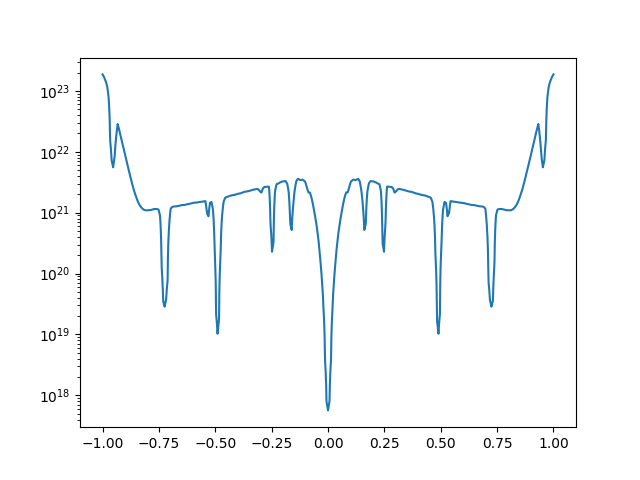

In [14]:
print(h1.K)
print(h1.R_y_PA.shape)

h1_W_f = h1.WhiteningFilter(mode="Averaging") # this function doesnt work with the averaged periodogram

The last step in the processing is to apply the Whitening Filter to the subdataset with the anomaly. To do this, a subdataset of size N centered in the anomaly time is taken from the original dataset.

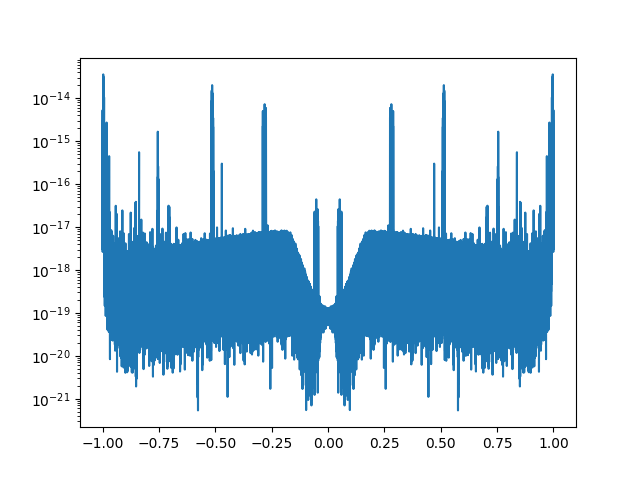

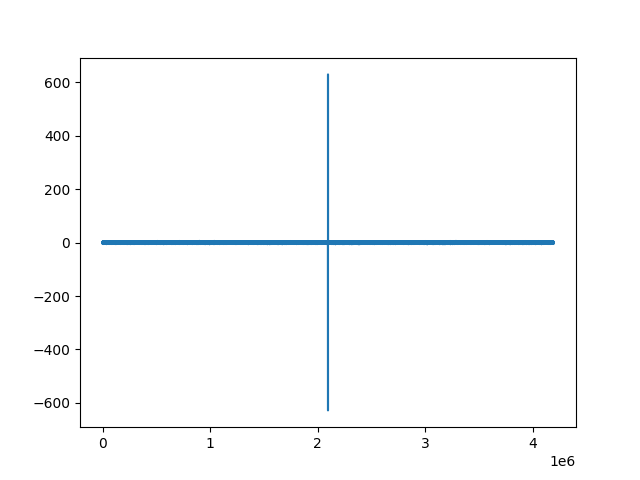

In [15]:
h1_result = h1.Whiten(N, 0.2)

Last but not least, a cropped segment of the restored signal is saved to a file

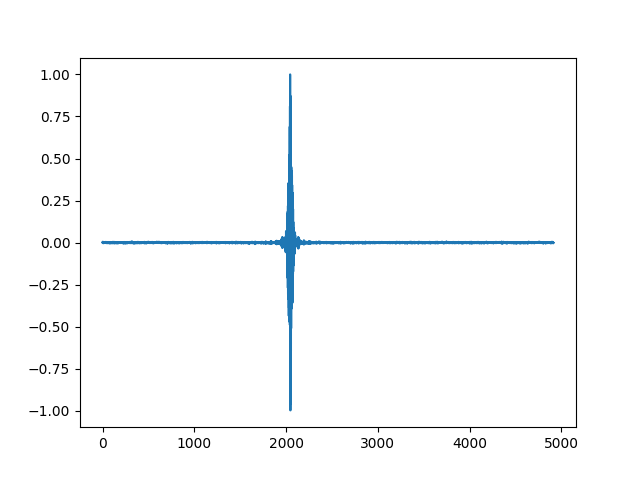

In [16]:
h1.SaveToFile(6, 0.5)

3) Estimation of the cone angle

In this last part of the script we will calculate the time delay of the two events to calculate the cone from where the signal could have came from

Maximum n value:  4194303  out of  16777216


C:\Users\jtori\PycharmProjects\PASA-P1-Marco\main.py:144: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


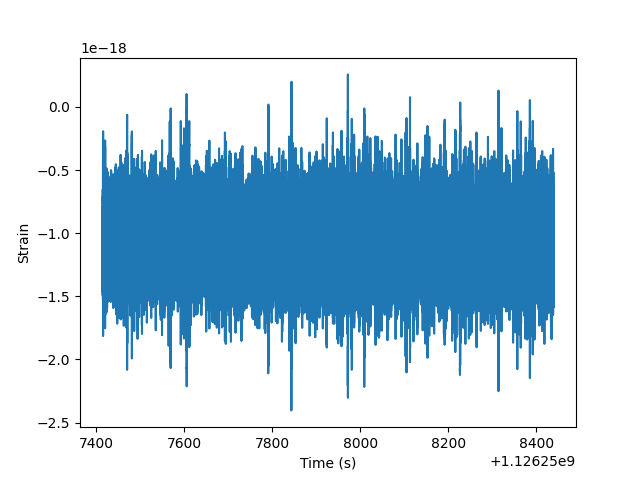

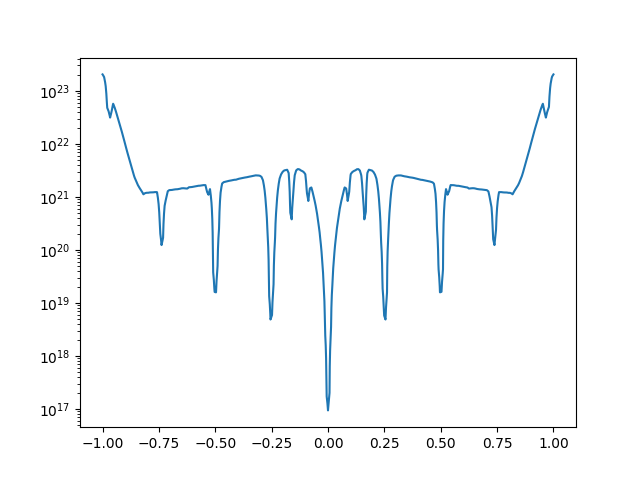

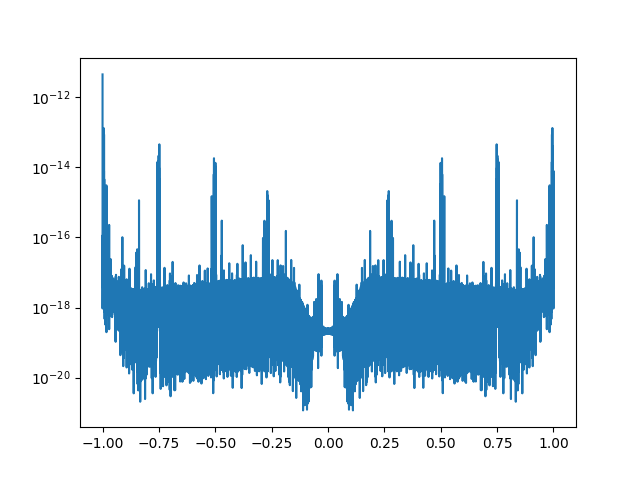

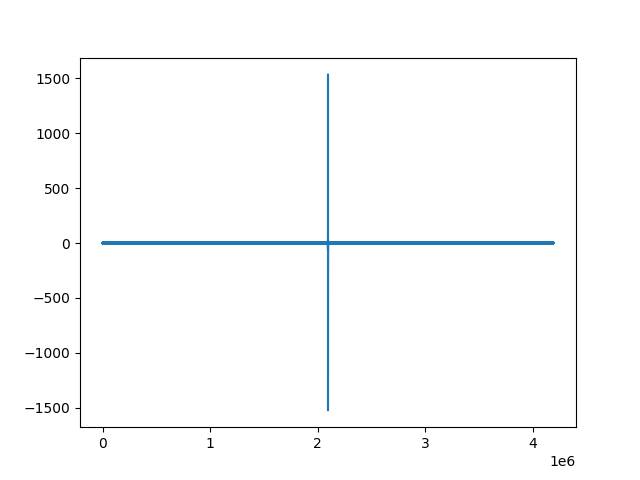

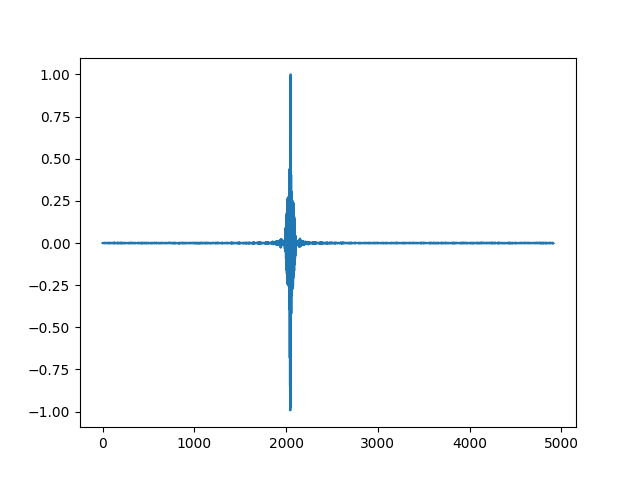

In [17]:
L1 = main.SignalProcessor(name="L1-4096-4K")
xValues_h1, yValues_h1, N_L1 = L1.Subdataset(startTime=start_time, endTime=anomaly_time)
L1.WindowSubdataset()
L1.Periodogram()
#L1.PeriodogramSmoothing(m=m)
L1.PeriodogramAveraging(L=300, D=0.5, window='Hanning')
l1_W_f = L1.WhiteningFilter()
l1_result = L1.Whiten(N_L1, 0.2)
L1.SaveToFile(6, 0.5)

In [18]:
cross_correlation_vector = sp.correlate(h1_result, l1_result, mode="full")
cross_correlation_lags = sp.correlation_lags(h1_result.size, l1_result.size, mode="full")
max_value_index = cross_correlation_vector.tolist().index(np.max(cross_correlation_vector))

304878


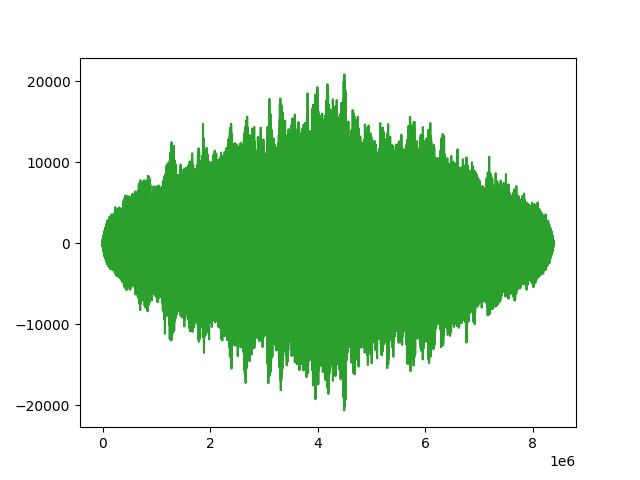

In [19]:
print(cross_correlation_lags[max_value_index])
plt.figure()
plt.plot(h1_result)
plt.plot(l1_result + 1)
plt.plot(cross_correlation_vector + 2)

1126257415
1126257415


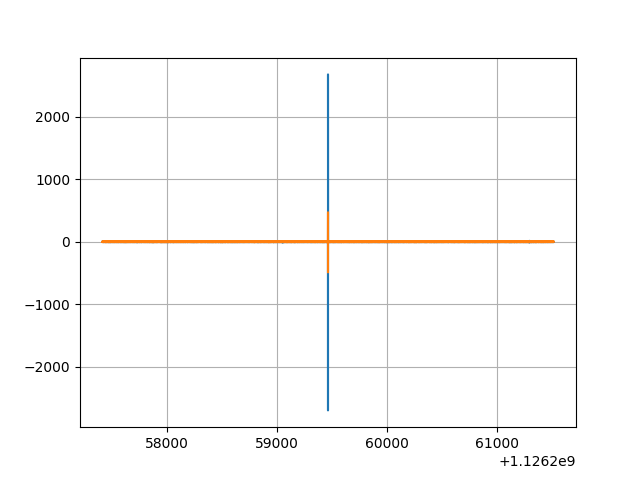

In [26]:
# Print overlapped H1 & L1
t_l1 = np.linspace(L1.XStart, L1.XStart + L1.N * L1.dX, L1.N)
t_h1 = np.linspace(h1.XStart, h1.XStart + h1.N * h1.dX, h1.N)

plt.figure()
print(L1.XStart)
print(h1.XStart)
L1_dset = L1.dset[()]
H1_dset = h1.dset[()]

w_f = np.fft.ifft(l1_W_f).real

w_f_scaled = np.zeros(L1_dset.shape[0])

start = (L1_dset.shape[0] - w_f.shape[0] ) // 2
w_f_scaled[start:start + w_f.shape[0]] = w_f

W_f_scaled = np.fft.fft(w_f_scaled)

L1_dset_f = np.fft.fft(L1_dset)
l1_filt = np.fft.ifft( L1_dset_f * W_f_scaled ).real

w_f = np.fft.ifft(h1_W_f).real
w_f_scaled = np.zeros(H1_dset.shape[0])
start = (H1_dset.shape[0] - w_f.shape[0] ) // 2
w_f_scaled[start:start + w_f.shape[0]] = w_f

correlation = sp.correlate(L1_dset, H1_dset, mode="same")
correlation_lags = sp.correlation_lags(L1_dset.shape[0], H1_dset.shape[0], mode="same")

max_corr_idx = correlation.tolist().index(max(correlation))

W_f_scaled = np.fft.fft(w_f_scaled)

H1_dset_f = np.fft.fft(H1_dset)
h1_filt = np.fft.ifft( H1_dset_f * W_f_scaled ).real
plt.close()
plt.figure()
plt.grid()
plt.plot(t_l1, l1_filt, t_h1, h1_filt*(-1))

690274


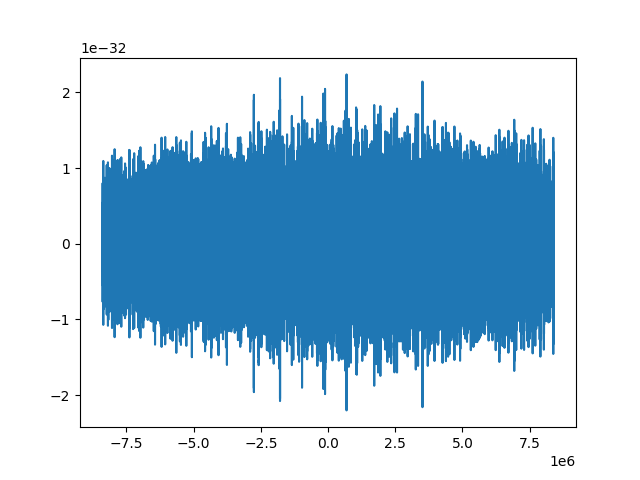

In [27]:
print(correlation_lags[max_corr_idx])
plt.figure()
plt.plot(correlation_lags, correlation)